# **05. Plotting a heatmap to visualize the effects of reweighting upon the predicted HDX-MS data**

In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

In [32]:
# Matplotlib settings for plotting
plt.rc('lines', linewidth=3, markersize=4)
plt.rc('axes', labelweight='heavy', labelsize=22, titlesize=22) # Default fontsizes for printing
plt.rc('axes.spines', top=False, right=False) # Switch off top/right axes
plt.rc('legend', fontsize=16) # Default fontsizes for printing
plt.rc('xtick', labelsize=16) # Default fontsizes for printing
plt.rc('ytick', labelsize=16) # Default fontsizes for printing
plt.rc('figure', titlesize=22, titleweight='heavy') # Default fontsizes for printing

Having selected a suitable $\gamma$ value at which to analyze our reweighted data, the next key step is to visualize and process the effects that reweighting has had. We might wish to study two main changes between the initial (unbiased) and reweighted ensemble:
1. How has reweighting changed the predicted HDX-MS data for the BPTI ensemble, compared to experiment?
2. How has reweighting changed the conformational populations of structures in the BPTI ensemble?

As we saw at he end of notebook 4, the multidimensional nature of HDX-MS data means it can be challenging to display the effects of reweighting in a convenient and intuitive way. A heatmap is a useful plot to visualize the changes in deuterated fractions from reweighting simultaneously for each residue and each time point. Using a heatmap, we can see which regions of proteins had the biggest changes in deuterated fractions (a.k.a. $\Delta$HDX) more clearly than by overlaying the deuterated fractions on a line plot, as in notebook 4. Following this analysis, we can also plot the $\Delta$HDX values directly onto relevant protein structures (for example from the candidate ensemble), and put the changes in HDX induced by reweighting directly into a structural context.

This notebook describes how to plot a heatmap of $\Delta$HDX values, and then displays the $\Delta$HDX values upon the 5PTI crystal structure of BPTI.

### **Script to sum segment averages and calculate $\Delta$HDX of (Reweighted HDX-MS - Initial predicted HDX-MS)**

In [33]:
# Setup variables
times = np.array([0.167, 1.0, 10.0, 120.0]) # Create a NumPy array with time points in minutes
labels = ("Reweighted", "Initial_predicted")
runs = 1

First, we read in the predicted deuterated fractions from the output files of reweighting, and from the output files of the **calc_hdx.py** HDX-MS predictions for the unbiased candidate ensemble. Note we have included a loop over a range of output files, the length of which is defined by a variable `runs`. In your own analyses you may wish to average these predictions across multiple different candidate ensembles (e.g. MD trajectories) and multiple reweighting analyses. Here, we've combined all of out BPTI trajectories together of course, so we set `runs = 1`.

In [34]:
# Import files
results1 = []
for run in range(1, runs+1):
    results1.append(np.loadtxt(os.path.expandvars('$HDXER_PATH/tutorials/BPTI/BPTI_reweighting/reweighting_gamma_2x10^0_final_segment_fractions.dat'), # Read in the reweighted deuterated fractions
                               dtype=[('fracs', np.float64, (len(times),))]))

results2 = []
for run in range(1, runs+1):
    results2.append(np.loadtxt(os.path.expandvars('$HDXER_PATH/tutorials/BPTI/BPTI_calc_hdx/BPTI_SUMMARY_segment_average_fractions.dat'), # Read in the predicted deuterated fractions
                               usecols=[1,2,3,4,5], dtype=[('res', np.int32, (1,)), ('fracs', np.float64, (len(times),))]))

Next, we perform the averaging of the predicted HDX-MS and calculate the differences in deuterated fractions: (Reweighted HDX-MS - Initial predicted HDX-MS).

In [35]:
mean1 = np.mean([_['fracs'] for _ in results1], axis=0)
mean2 = np.mean([_['fracs'] for _ in results2], axis=0)

diffs = mean1 - mean2

Next, save the differences into a text file (`%s-%s_diffs.dat`).

In [37]:
np.savetxt(os.path.expandvars('$HDXER_PATH/tutorials/BPTI/BPTI_reweighting/%s-%s_diffs.dat') % labels, np.concatenate((results2[0]['res'], diffs), axis=1), \
           fmt="%3d " + "%8.5f "*4, header="ResID  Times / min: 0.167 1.0 10.0 120.0")

The `%s-%s_diffs.dat` file contains the residue-based $\Delta$HDX values and residue numbers and can be used to recreate the plot without re-reading the original data.

Finally, we plot a heatmap of the $\Delta$HDX values for each residue and timepoint. The columns in the heatmap below represent the $\Delta$HDX obseved for each BPTI residue, while the rows represent the $\Delta$HDX across each labeling timepoint present in the HDX-MS data. Each square, denoting the $\Delta$HDX for a specific residue and timepoint combination, is then colored according to the $\Delta$(Reweighted HDX-MS - Initial predicted HDX-MS).

Negative values, meaning that the reweighted ensemble is *more protected* from exchange than the original unbiased ensemble, are shown in blue. Positive values, meaning that the reweighted ensemble is *more deuterated* than the original unbiased ensemble, are shown in red. Residues and timepoints for which no change is observed are shown in white.

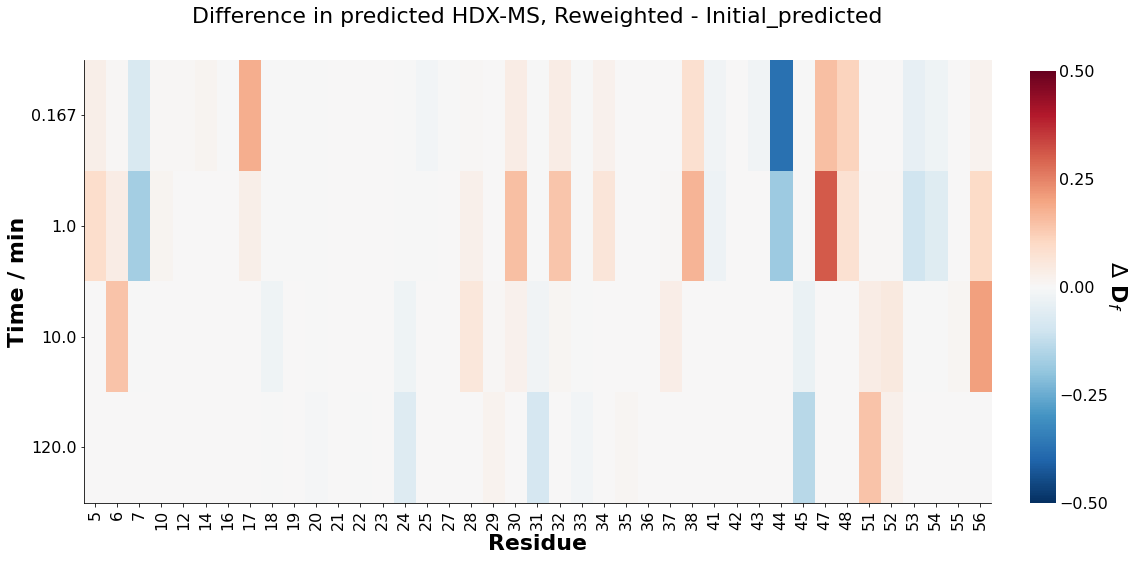

In [39]:
reslist = np.loadtxt(os.path.expandvars('$HDXER_PATH/tutorials/BPTI/BPTI_reweighting/%s-%s_diffs.dat') % labels, dtype=[('res', np.int32, (1,))], usecols=(0,))
diffs = np.loadtxt(os.path.expandvars('$HDXER_PATH/tutorials/BPTI/BPTI_reweighting/%s-%s_diffs.dat') % labels, usecols=(1,2,3,4))

xs = reslist['res'].flatten()

# Make heatmap. Any changes > +/- 0.5 will be displayed in full color
fig, axs = plt.subplots(1,1, figsize=(18, 12))

img = axs.imshow(diffs.T, cmap='RdBu_r', aspect=5.0, vmin=-0.5, vmax=0.5, interpolation='none')
axs.set_anchor('S')
axs.set_xticks(range(len(xs)))
axs.set_xticklabels(xs, rotation=90)
axs.set_xlabel("Residue", y=2)
axs.set_yticks(list(range(len(times))))
axs.set_yticklabels(times)
axs.set_ylabel("Time / min")
axs.set_title("Difference in predicted HDX-MS, %s - %s" % labels, y=1.07)

# Set size & location of colorbar
fig.subplots_adjust(bottom=0.1, top=0.75, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.16)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.50])

cbar = fig.colorbar(img, cax=cb_ax, ticks=np.arange(-0.5,0.75,0.25))
cbar.ax.set_ylabel(r"$\Delta$ D$_f$", rotation=270., labelpad=20)
cbar.ax.tick_params(axis='both', which='both',length=0)
cbar.outline.remove()
plt.savefig('BPTI_heatmap.png', bbox_inches='tight')

At this point, more in-depth analysis of the appropriately-weighted structures present in the final ensemble can be carried out however you desire. In this case, the difference that reweighting makes to the final predicted deuterated fractions is not uniformly distributed across the entire protein. For example, reweighting does not seem to affect the predicted deuteration between residues 18-29, in which the initital predicted deuterated fractions agree well with the target data. In comparison, the difference is larger for the residues 44-56, which are located closer to the C-terminus.

We can make a better structural interpretation by overlaying the difference between reweighted and initial predicted deuterated fractions onto a BPTI structure. We shared two scripts inside the ```BPTI_reweighting``` directory that will help us in this process. A Python script (**bfactor_mdtraj.py**) first creates an individual PDB file with the difference in deuterated fractions overlayed on each residue for each labeling time. Then, we can use a Pymol script (**color_by_bfactor.pml**) to visualize and save an image of BPTI with the difference in deuterated fractions overlayed.

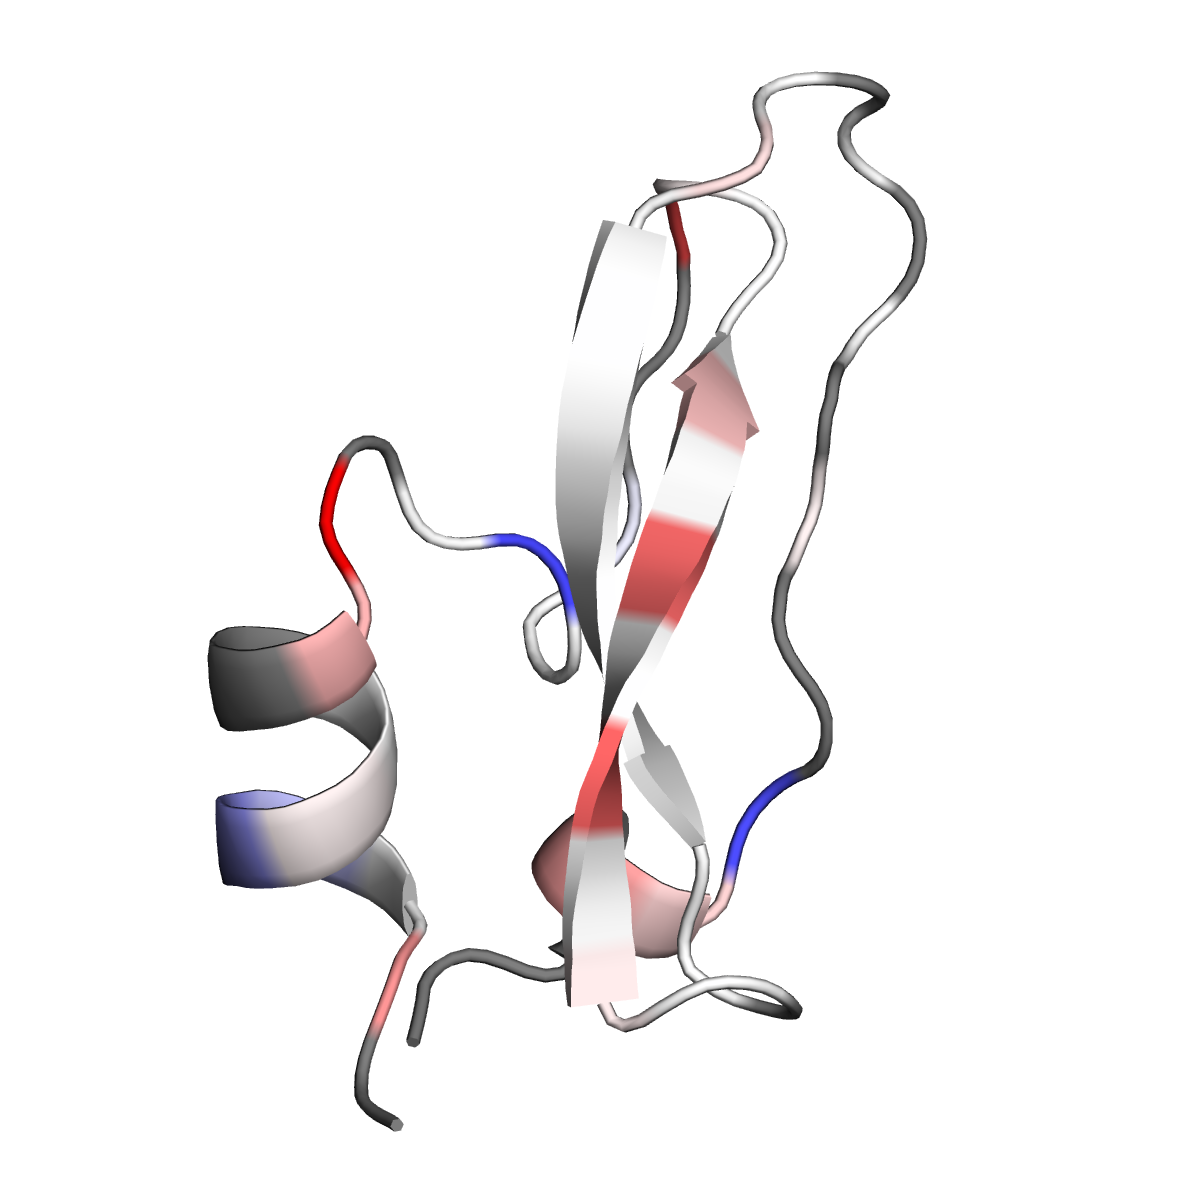

In [50]:
# Load an image of BPTI structure (5PTI) with the difference in deuterated fractions for 1 minute labeling time
Image(os.path.expandvars('$HDXER_PATH/tutorials/BPTI/BPTI_reweighting/Reweighted-Predicted_byatom_1min.png'), width=800)